In [2]:
%run funciones.py
import pandas as pd
from funciones import *
import json, keras, subprocess, time
import tensorflow as tf
from tensorflow.python.platform import build_info as build
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, RepeatVector, TimeDistributed, ConvLSTM2D, Flatten, Reshape

print("Tensorflow".ljust(25) + f":{tf.__version__}")
print("Keras".ljust(25) + f":{keras.__version__}")
print("GPU Available".ljust(25) + f":{len(tf.config.experimental.list_physical_devices('GPU'))}")
print("Cuda Built".ljust(25) + f":{tf.test.is_built_with_cuda()}")
print("Cuda Version".ljust(25) + f":{build.build_info['cuda_version']}")
print("Cudnn Version".ljust(25) + f":{build.build_info['cudnn_version']}")
print("List Tensorflow GPUs".ljust(25) + f":{tf.config.list_physical_devices('GPU')}")
print("Name of GPU".ljust(25) + f":{subprocess.check_output('nvidia-smi --query-gpu=gpu_name --format=csv', shell=True).decode().splitlines()[1]}")
print("Numpy Version".ljust(25) + f":{np.__version__}")
print("Pandas Version".ljust(25) + f":{pd.__version__}")
#print("Matplotlib Version".ljust(25) + f":{matplotlib.__version__}")
#print("Seaborn Version".ljust(25) + f":{sns.__version__}")

Tensorflow               :2.10.1
Keras                    :2.10.0
GPU Available            :1
Cuda Built               :True
Cuda Version             :64_112
Cudnn Version            :64_8
List Tensorflow GPUs     :[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Name of GPU              :NVIDIA GeForce RTX 3070 Ti Laptop GPU
Numpy Version            :1.24.3
Pandas Version           :1.5.3


# Dataset y configuración de parametros

In [3]:
# ============================== PARAMETROS DEL DATASET ==============================
div_split = 83
INPUT_LENGTH, OUTPUT_LENGTH = 83, 1
SCALER = 'Robust' 
CONVOLUTIONAL = False
name_dataset = "travel_times.csv"

# leer dataset
cols = ['id_linkref', 'horas', 'minute', 'travel_time']
origin_dataset = pd.read_csv('../data/travel_times.csv', sep=',', usecols=cols)
dataset = origin_dataset[cols]

# delimitar links (0, 82)
range_links = (0, 82)
if range_links != (0, 82):
    dataset =  dataset[(dataset['id_linkref']>= range_links[0]) & (dataset['id_linkref']<=range_links[1])]
    
print(f"Data set delimitado con Links desde {range_links[0]} - {range_links[1]} => {len(dataset['id_linkref'].unique())} links")

# preparar dataset
data, scaler = cargar_dataset(dataset, div_split, (INPUT_LENGTH, OUTPUT_LENGTH), name_scaler=SCALER, conv=False)

# extraer dataset escalado
x_tr_s, y_tr_s = data['x_tr_s'], data['y_tr_s']
x_vl_s, y_vl_s = data['x_vl_s'], data['y_vl_s']
x_ts_s, y_ts_s = data['x_ts_s'], data['y_ts_s']

if CONVOLUTIONAL:
    # Redimensionar los conjuntos de datos para el modelo ConvLSTM
    x_tr_s = x_tr_s.reshape(x_tr_s.shape[0], x_tr_s.shape[1], x_tr_s.shape[2], 1, 1)
    x_vl_s = x_vl_s.reshape(x_vl_s.shape[0], x_vl_s.shape[1], x_vl_s.shape[2], 1, 1)
    x_ts_s = x_ts_s.reshape(x_ts_s.shape[0], x_ts_s.shape[1], x_ts_s.shape[2], 1, 1)

# crear directorios para los modelos de cada gpu que se esta utilizando
name_gpu = subprocess.check_output('nvidia-smi --query-gpu=gpu_name --format=csv', shell=True).decode().splitlines()[1]
create_dir_gpu(name_gpu)

print("Modelo a entrenar:", 'Conv2DLSTM' if CONVOLUTIONAL == True else "LSTM")
print('Shape del conjuntos de datos: ',x_tr_s.shape, x_vl_s.shape ,x_ts_s.shape)

Data set delimitado con Links desde 0 - 82 => 83 links
Directorios listos para: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Modelo a entrenar: LSTM
Shape del conjuntos de datos:  (173718, 83, 4) (24733, 83, 4) (49633, 83, 4)


In [4]:
# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# =============================== HIPERPARAMETROS DEL MODELO ===============================

# Input shape del modelo LSTM
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # dimensiones del input

# Input shape del modelo Conv2DLSTM
if CONVOLUTIONAL:
    INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2], 1, 1)

N_UNITS = 128 # unidades del LSTM
name_opt = 'RMSprop-lr5e-5'
ACT = 'linear' # funcion de activacion
name_function_loss = 'rmse'

# optimizador
opt = RMSprop(learning_rate=5e-5)

# funcion de perdida
def rmse(y_true, y_pred): 
    return tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true))) 

# LSTM Models

In [5]:
# ================================= MODELO 1 =================================
n_modelo = 'BASE-LSTM'
modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE, return_sequences = False))
modelo.add(Dense(OUTPUT_LENGTH, activation=ACT))

# Compilación
modelo.compile(optimizer = opt, loss = rmse, metrics=['mae', 'mape'])

In [6]:
# ================================= MODELO 2 =================================
# n_modelo = 'AUTOENCODER-LSTM'
# modelo = Sequential()
# modelo.add(BatchNormalization(name = 'batch_norm_0', input_shape = INPUT_SHAPE))
# modelo.add(LSTM(name ='lstm_1', units = N_UNITS, return_sequences = True))
# modelo.add(Dropout(0.15, name = 'dropout_1'))
# modelo.add(BatchNormalization(name = 'batch_norm_1'))
# modelo.add(LSTM(name ='lstm_2', units = N_UNITS, return_sequences = False))
# modelo.add(Dropout(0.1, name = 'dropout_2'))
# modelo.add(BatchNormalization(name = 'batch_norm_2'))
# modelo.add(RepeatVector(1))
# modelo.add(LSTM(name ='lstm_3', units = N_UNITS, return_sequences = True))
# modelo.add(Dropout(0.15, name = 'dropout_3'))
# modelo.add(BatchNormalization(name = 'batch_norm_3'))
# modelo.add(LSTM(name ='lstm_4', units = N_UNITS, return_sequences = False))
# modelo.add(Dense(units = OUTPUT_LENGTH, name = 'dense_1', activation = ACT))

# # Compilación
# modelo.compile(optimizer = opt, loss = rmse, metrics=['mae', 'mape'])

# Conv2DLSTM Models

In [7]:
# ================================= MODELO 1 =================================
# n_modelo = 'BASE-Conv2DLSTM'
# modelo = Sequential()
# modelo.add(BatchNormalization(name = 'batch_norm_0', input_shape = INPUT_SHAPE))
# modelo.add(ConvLSTM2D(name ='lstm_1', filters=N_UNITS, kernel_size=(10, 1), padding = 'same', return_sequences = False))
# modelo.add(Dense(units = OUTPUT_LENGTH, name = 'dense_1', activation = ACT))

# # # Compilación
# modelo.compile(optimizer = opt, loss = rmse, metrics=['mae', 'mape'])

In [8]:
# ================================= MODELO 2 =================================
# n_modelo = 'AUTOENCODER-Conv2DLSTM'
# modelo = Sequential()
# modelo.add(BatchNormalization(name = 'batch_norm_0', input_shape = INPUT_SHAPE))
# modelo.add(ConvLSTM2D(name ='lstm_1', filters=N_UNITS, kernel_size=(10, 1), padding = 'same', return_sequences = True))
# modelo.add(Dropout(0.10, name = 'dropout_1'))
# modelo.add(BatchNormalization(name = 'batch_norm_1'))

# modelo.add(ConvLSTM2D(name ='conv_lstm_2', filters = N_UNITS, kernel_size = (10, 1), padding='same', return_sequences = False))
# modelo.add(Dropout(0.10, name = 'dropout_2'))
# modelo.add(BatchNormalization(name = 'batch_norm_2'))
# modelo.add(Flatten())
# modelo.add(RepeatVector(1))
# modelo.add(Reshape((1, 4, 1, N_UNITS)))

# modelo.add(ConvLSTM2D(name ='conv_lstm_3', filters = N_UNITS, kernel_size = (10, 1), padding='same', return_sequences = True))
# modelo.add(Dropout(0.10, name = 'dropout_3'))
# modelo.add(BatchNormalization(name = 'batch_norm_3')) 

# modelo.add(ConvLSTM2D(name ='conv_lstm_4', filters = N_UNITS, kernel_size = (10, 1), padding='same', return_sequences = False))
# modelo.add(Dense(units = OUTPUT_LENGTH, name = 'dense_1', activation = ACT))

# # Compilación
# modelo.compile(optimizer = opt, loss = rmse, metrics=['mae', 'mape'])

# Entrenamiento

In [9]:
#modelo.summary()

In [10]:
# parametros de entrenamiento
EPOCHS = 25 # 25 - 50 - 75 - 100 - 125 - 150 - 175 - 200
BATCH_SIZE = 256 

# Iniciar el contador de tiempo
start_time = time.time()

# Entrenamiento
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s)
)

# Calcular el tiempo de entrenamiento en segundos
training_time = {'GPU': name_gpu,
                 'training_time': time.time() - start_time}

# GUARDAR MODELO
name_files = f"{n_modelo}_e{EPOCHS}b{BATCH_SIZE}_{SCALER}_in{INPUT_SHAPE[0]}-{INPUT_SHAPE[1]}_dt{range_links[0]}-{range_links[1]}"

modelo.save(f"../models/{name_gpu}/{name_files}.h5")
print('Entrenamiento finalizado y modelo guardado')
print('\nEVALUANDO MODELO')

# Cálculo de rmses para train, val y test
rmse_dict = {'train':modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=1), 
             'val':  modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=1), 
             'test': modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=1)}

print('\nCALCULANDO RMSE-MAE-MAPE REAL')

y_tr_pred = predecir(x_tr_s, modelo, scaler, CONVOLUTIONAL)
y_ts_pred = predecir(x_ts_s, modelo, scaler, CONVOLUTIONAL)
y_vl_pred = predecir(x_vl_s, modelo, scaler, CONVOLUTIONAL)

tr_metrics = RMSE_MAE_MAPE_seconds(data['y_tr'], y_tr_pred)
vl_metrics = RMSE_MAE_MAPE_seconds(data['y_vl'], y_vl_pred)
ts_metrics = RMSE_MAE_MAPE_seconds(data['y_ts'], y_ts_pred)

rmse_dict_seconds = {'train rmse-mae-mape real': tr_metrics, 
                     'val rmse-mae-mape real': vl_metrics, 
                     'test rmse-mae-mape real': ts_metrics}

# recolectar hiperparametros
param_dataset = {
    'range_links': range_links,
    'div_split': div_split,
    'INPUT_LENGTH': INPUT_LENGTH,
    'OUTPUT_LENGTH': OUTPUT_LENGTH,
    'scaler': SCALER,
    'isCONV': CONVOLUTIONAL,
    'name_dataset': name_dataset
}

param_model ={
    'n_modelo': n_modelo,
    'epoch': EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'INPUT_SHAPE': INPUT_SHAPE,
    'n_unist-LSMT': N_UNITS,
    'name_optimizer': name_opt,
    'name_function_activation': ACT,
    'name_function_loss': name_function_loss, 
}

# GUARDAR DATOS DE ENTRENAMIENTO
hist_df = pd.DataFrame(historia.history)  
with open(f'../info_models/{name_gpu}/{name_files}.json', mode='w') as f:
    temp = {**param_model, **hist_df.to_dict('list'), **rmse_dict, **rmse_dict_seconds, **param_dataset,  **training_time}
    json.dump(temp, f)
    print('Historial y evaluación correctamente guardados')

Epoch 1/25
679/679 [==============================] - 11s 10ms/step - loss: 0.9832 - mae: 0.6491 - mape: 3158876.0000 - val_loss: 0.9546 - val_mae: 0.6231 - val_mape: 2792459.7500
Epoch 2/25
679/679 [==============================] - 6s 9ms/step - loss: 0.9394 - mae: 0.6112 - mape: 3289681.0000 - val_loss: 0.9240 - val_mae: 0.6029 - val_mape: 3258670.2500
Epoch 3/25
679/679 [==============================] - 6s 9ms/step - loss: 0.9166 - mae: 0.5938 - mape: 3523136.7500 - val_loss: 0.9045 - val_mae: 0.5901 - val_mape: 3353212.5000
Epoch 4/25
679/679 [==============================] - 6s 9ms/step - loss: 0.9002 - mae: 0.5807 - mape: 3520352.7500 - val_loss: 0.8881 - val_mae: 0.5717 - val_mape: 3155694.0000
Epoch 5/25
679/679 [==============================] - 6s 9ms/step - loss: 0.8874 - mae: 0.5702 - mape: 3433786.7500 - val_loss: 0.8778 - val_mae: 0.5744 - val_mape: 3176038.0000
Epoch 6/25
679/679 [==============================] - 6s 9ms/step - loss: 0.8720 - mae: 0.5601 - mape: 33588

In [11]:
Print_Real_Metrics(tr_metrics, vl_metrics, ts_metrics)

Comparativo de desempeños con los conjuntos de datos y las predicciones del modelo en segundos:
  RMSE train:	 35.636
  RMSE val:	 35.844
  RMSE test:	 35.244

  MAE train:	 22.574
  MAE val:	 22.824
  MAE test:	 22.587

  MAPE train:	 0.586
  MAPE val:	 0.604
  MAPE test:	 0.579


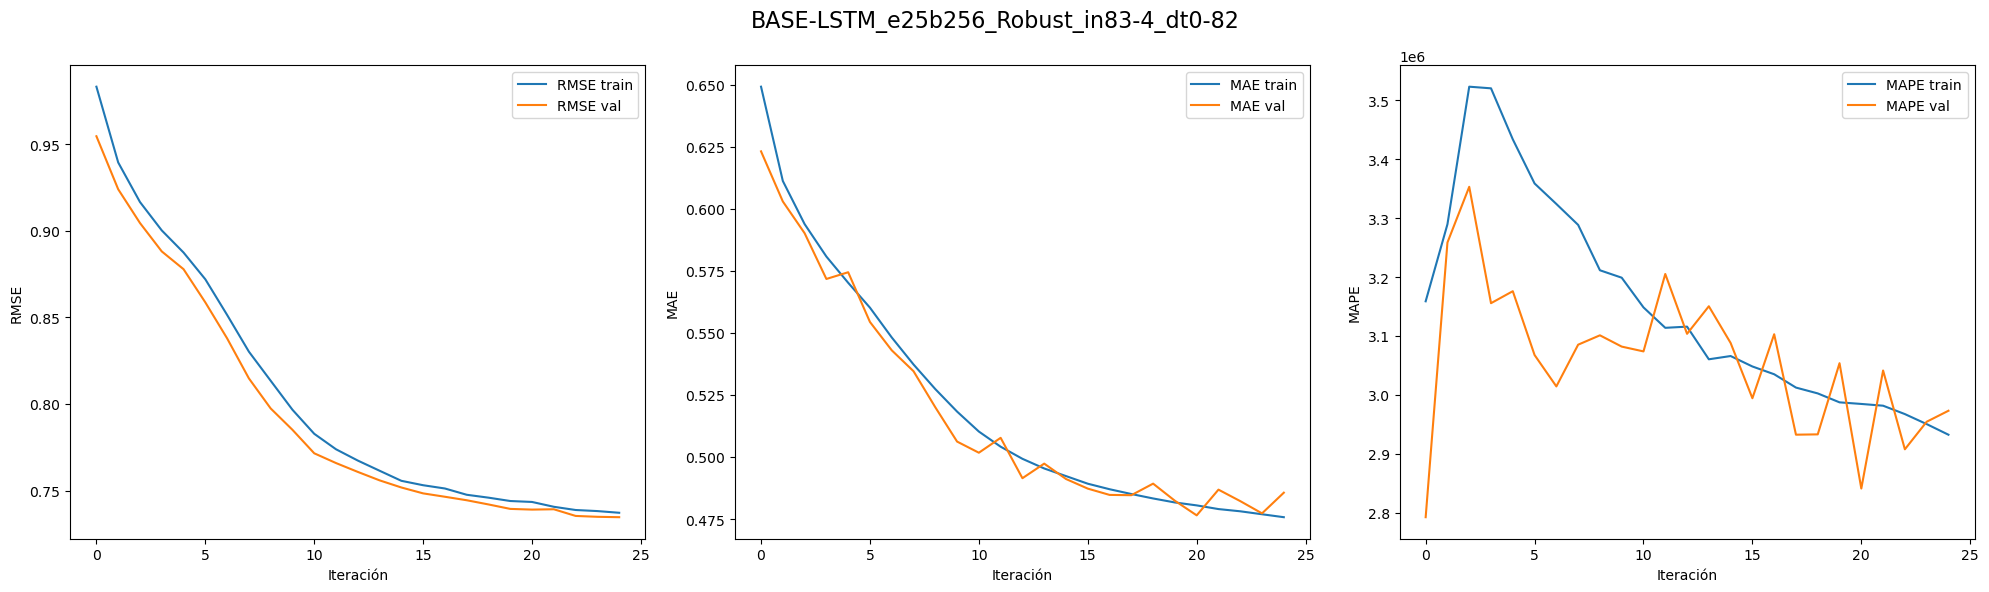

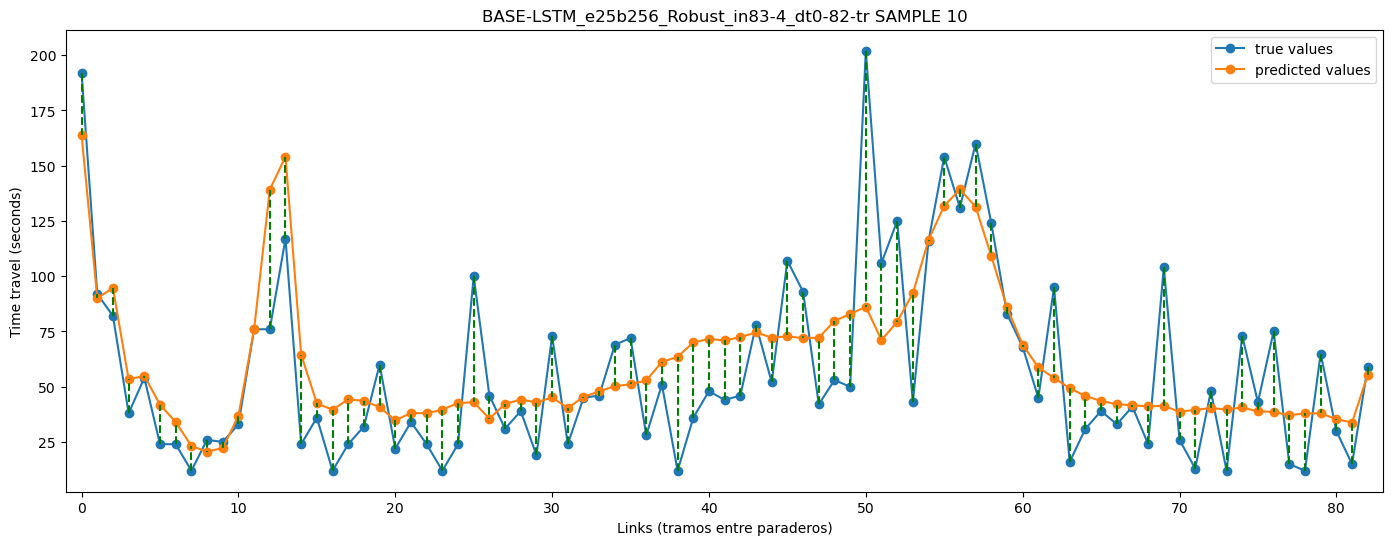

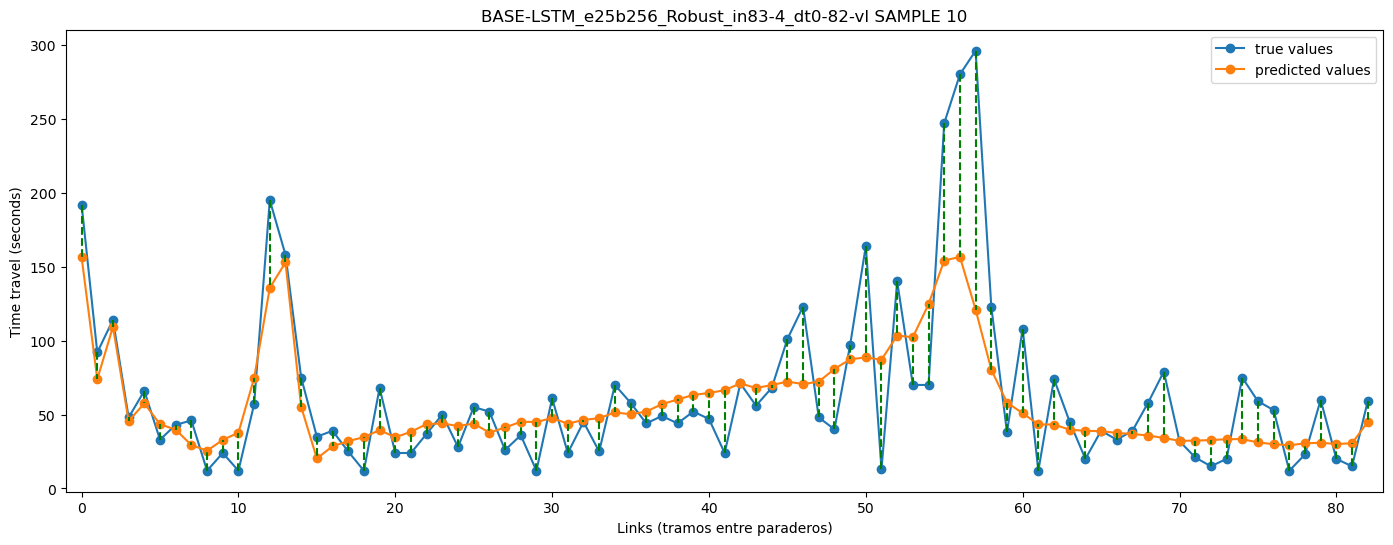

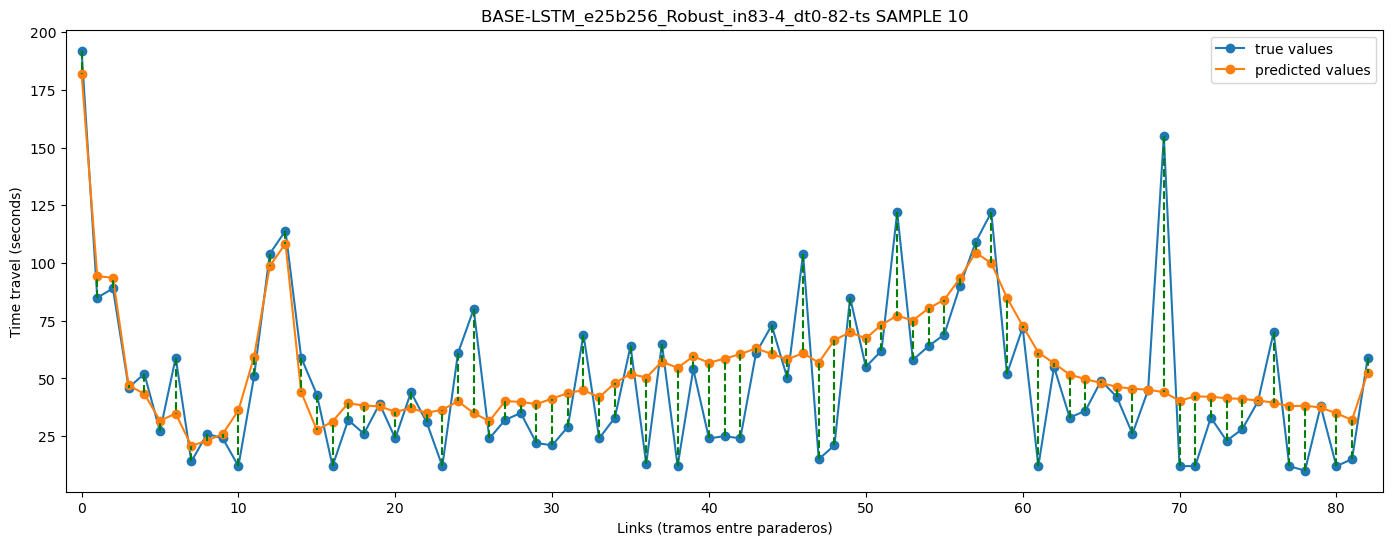

In [12]:
# mostrar y guardar grafica de entrenamiento y de predicciones
plot_history_model(historia, save_dir=f"../graphs/{name_gpu}/{name_files}.png", title = f'{name_files}')

n_sample = 10
plot_predict_samples(n_sample, data['y_tr'], y_tr_pred, save_directory=f"../graphs/{name_gpu}/preds/{n_modelo}e{EPOCHS}-tr-s{n_sample}.png", name_model=f"{name_files}-tr")
plot_predict_samples(n_sample, data['y_vl'], y_vl_pred, save_directory=f"../graphs/{name_gpu}/preds/{n_modelo}e{EPOCHS}-vl-s{n_sample}.png", name_model=f"{name_files}-vl")
plot_predict_samples(n_sample, data['y_ts'], y_ts_pred, save_directory=f"../graphs/{name_gpu}/preds/{n_modelo}e{EPOCHS}-ts-s{n_sample}.png", name_model=f"{name_files}-ts")